In [1]:
import numpy as np


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [2]:
# error probabilties, I took the following value randomly
#wondering should I take them randomly
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
measure_error = 0.2 # P(measure error)
gate_error = 0.05 # P(two qubit error)

# calling error functions using from IBM library
re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
gate_err2 = gate_err1.tensor(gate_err1)

# errors on a noisy model
bitflip_err = NoiseModel()
bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")

print(bitflip_err)



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['measure', 'u2', 'u3', 'reset', 'u1', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [47]:
def bit_error(circ, qubits):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error


    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    bitflip_err = NoiseModel()
    bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
    bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
    bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()

    legend = ['ideal', 'bit_flip']

    # Plot noisy output
    plot_bit = plot_histogram([ideal_counts, counts_bit_flip], legend= legend)
    display(plot_bit)
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_bit_flip.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_bit_flip:
            counts_bit_flip[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    for key in ideal_counts:
        print(ideal_counts[key], counts_bit_flip[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_bit_flip[key]/N2)
        print(tvd)
    
    return plot_bit, tvd

def ideal(circ):
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()

    
    return ideal_counts, ideal_counts, counts_bit_flip

In [7]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()

┌───┐          ┌─┐      
q12_0: ┤ H ├──■───────┤M├──────
       └───┘┌─┴─┐     └╥┘┌─┐   
q12_1: ─────┤ X ├──■───╫─┤M├───
            └───┘┌─┴─┐ ║ └╥┘┌─┐
q12_2: ──────────┤ X ├─╫──╫─┤M├
                 └───┘ ║  ║ └╥┘
 c1: 3/════════════════╩══╩══╩═
                       0  1  2

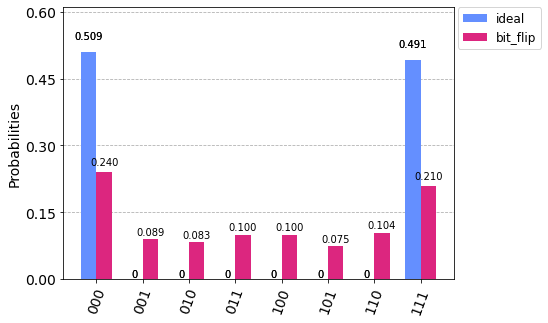

503 215
0.140625
521 246
0.27490234375
0 91
0.3193359375
0 85
0.36083984375
0 102
0.41064453125
0 102
0.46044921875
0 77
0.498046875
0 106
0.5498046875


(<Figure size 504x360 with 1 Axes>, 0.5498046875)

In [48]:
bit_error(ghz_circ, len(q_ghz))

In [52]:
def t1_t2(qubits, circ):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()
    
    
    # Run the noisy simulation
    sim_thermal = AerSimulator(noise_model=noise_thermal)

    # Transpile circuit for noisy basis gates
    tthermal = transpile(circ, sim_thermal)

    # Run and get counts
    result_thermal = sim_thermal.run(tthermal).result()
    counts_thermal = result_thermal.get_counts()
    legend_t = ['ideal', 'thermal']

    # Plot noisy output
    plot_thermal = plot_histogram([ideal_counts, counts_thermal], legend= legend_t)
    display(plot_thermal)
    
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_bit_flip.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_thermal:
            counts_thermal[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_bit_flip[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_thermal[key]/N2)
        print(tvd)
    
    return plot_thermal, tvd

    

In [10]:
def depolar(qubits, circ):

    p_gate = 0.1
    error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_depolar = NoiseModel()
    noise_depolar.add_all_qubit_quantum_error(error_meas, "measure", qubits)
    
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()

    # Run the noisy simulation
    sim_depolar = AerSimulator(noise_model=noise_depolar)

    # Transpile circuit for noisy basis gates
    depolar = transpile(circ, sim_depolar)

    # Run and get counts
    result_depolar = sim_depolar.run(depolar).result()
    counts_depolar = result_depolar.get_counts()
    legend_t = ['ideal', 'depolar']

    # Plot noisy output
    plot_depolar = plot_histogram([ideal_counts, counts_depolar], legend= legend_t)
    display(plot_depolar)
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_bit_flip.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_bit_flip:
            counts_bit_flip[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    for key in ideal_counts:
        print(ideal_counts[key], counts_bit_flip[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_bit_flip[key]/N2)
        print(tvd)
                              
    
    return plot_depolar, tvd

In [11]:
def tvd_calculator(dist_1, dist_2, num_qubits):
    """This function accepts two counts distributions as dictionaries
    and computes the total variation distribution (TVD) between them

    Args:
        dist1 & dist2: counts dictionary from IBM backend/simulator.
               example, {'00': 4000, '01': 4192}
        num_qubits: number of measured qubits in the qunatum circuits.

    Returns:
        tvd: Total variation distribution between two distributions
    """
    num_binary_states = 2**num_qubits

    # get the total counts for two dictionaries
    N1 = sum(dist_1.values())
    N2 = sum(dist_2.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**num_qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(num_qubits)

        if binary_state not in dist_1:
            dist_1[binary_state] = 0
        
        if binary_state not in dist_2:
            dist_2[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    for key in dist_1:
        print(dist_1[key], dist_2[key])
        tvd = tvd + 0.5 * abs(dist_1[key]/N1 - dist_2[key]/N2)

    return tvd


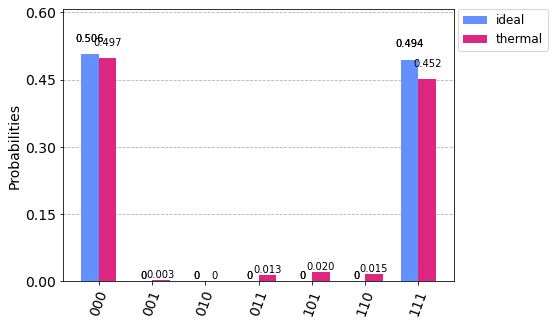

506 236
0.02099609375
518 233
0.025390625
0 113
0.02685546875
0 92
0.02734375
0 90
0.03369140625
0 88
0.03369140625
0 63
0.04345703125
0 109
0.05078125


(<Figure size 504x360 with 1 Axes>, 0.05078125)

In [20]:
t1_t2(len(q_ghz), ghz_circ)

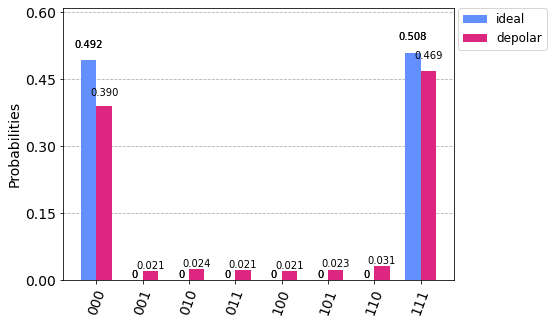

504 240
0.12890625
520 233
0.26904296875
0 96
0.31591796875
0 89
0.359375
0 99
0.40771484375
0 88
0.45068359375
0 84
0.49169921875
0 95
0.5380859375


(<Figure size 504x360 with 1 Axes>, 0.5380859375)

In [13]:
depolar(len(q_ghz), ghz_circ)

In [13]:
print(noise_depolar)

NameError: name 'noise_depolar' is not defined

In [14]:
#Mermin_Bell gate
from math import pi
mer_bell = QuantumRegister(3)
mer_bell_c =  ClassicalRegister(3)
mer_bell_circ = QuantumCircuit(mer_bell, mer_bell_c)
mer_bell_circ.rx(-pi/2, mer_bell[0])
mer_bell_circ.cx(mer_bell[0], mer_bell[1])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cx(mer_bell[0], mer_bell[2])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.cx(mer_bell[2], mer_bell[0])
mer_bell_circ.cx(mer_bell[1], mer_bell[0])
mer_bell_circ.s(mer_bell[2])
mer_bell_circ.s(mer_bell[0])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cz(mer_bell[0], mer_bell[1])
mer_bell_circ.h(mer_bell[0])
mer_bell_circ.s(mer_bell[1])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.measure(mer_bell[0:3], mer_bell_c[0:3])
display(mer_bell_circ.draw())
                           

┌──────────┐                         ┌───┐┌───┐┌───┐   ┌───┐     ┌─┐   
q70_0: ┤ Rx(-π/2) ├──■──────────────■───────┤ X ├┤ X ├┤ S ├─■─┤ H ├─────┤M├───
       └──────────┘┌─┴─┐     ┌───┐  │       └─┬─┘└─┬─┘└───┘ │ ├───┤┌───┐└╥┘┌─┐
q70_1: ────────────┤ X ├──■──┤ H ├──┼────■────┼────■────────■─┤ S ├┤ H ├─╫─┤M├
                   └───┘┌─┴─┐├───┤┌─┴─┐┌─┴─┐  │  ┌───┐┌───┐┌─┐└───┘└───┘ ║ └╥┘
q70_2: ─────────────────┤ X ├┤ H ├┤ X ├┤ X ├──■──┤ S ├┤ H ├┤M├───────────╫──╫─
                        └───┘└───┘└───┘└───┘     └───┘└───┘└╥┘           ║  ║ 
 c2: 3/═════════════════════════════════════════════════════╩════════════╩══╩═
                                                            2            0  1

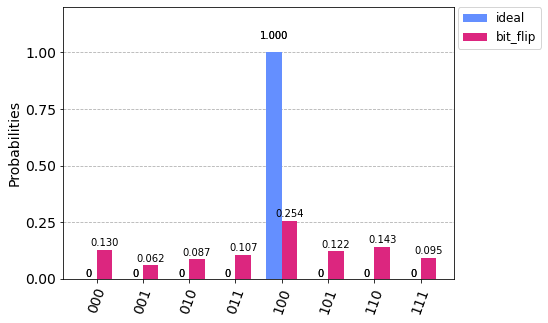

1024 260
0 133
0 64
0 89
0 110
0 125
0 146
0 97


(<Figure size 504x360 with 1 Axes>, 0.74609375)

In [22]:
bit_error(mer_bell_circ, len(mer_bell))

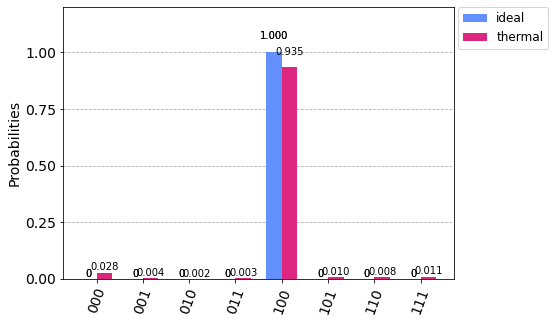

100
1024 260
0.03271484375
000
0 126
0.046875
001
0 73
0.048828125
010
0 89
0.0498046875
011
0 84
0.05126953125
101
0 132
0.05615234375
110
0 138
0.06005859375
111
0 122
0.0654296875


(<Figure size 504x360 with 1 Axes>, 0.0654296875)

In [55]:
t1_t2(len(mer_bell), mer_bell_circ)


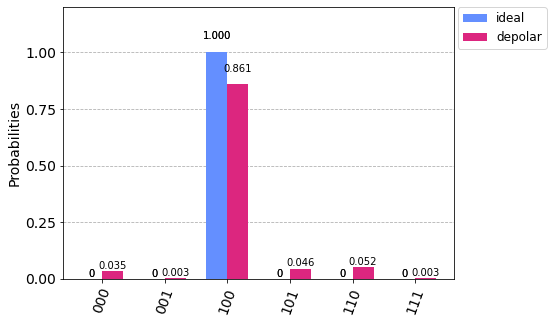

1024 262
0.3720703125
0 141
0.44091796875
0 72
0.47607421875
0 87
0.5185546875
0 101
0.56787109375
0 111
0.6220703125
0 150
0.6953125
0 100
0.744140625


(<Figure size 504x360 with 1 Axes>, 0.744140625)

In [24]:
depolar(len(mer_bell), mer_bell_circ)

In [49]:
#phase code
phase_q = QuantumRegister(5)
phase_c = ClassicalRegister(5)
phase_circ = QuantumCircuit(phase_q, phase_c)
phase_circ.h(phase_q[0])
phase_circ.initialize([1,0], 1)
phase_circ.x(phase_q[2])
phase_circ.initialize([1,0], 3)
phase_circ.h(phase_q[4])
phase_circ.h(phase_q[0:5])
phase_circ.cz(phase_q[0], phase_q[1])
phase_circ.h(phase_q[2])
phase_circ.h(phase_q[0])
phase_circ.cz(phase_q[1], phase_q[2])
phase_circ.h(phase_q[1])
phase_circ.cz(phase_q[2], phase_q[3])
phase_circ.h(phase_q[2])
phase_circ.cz(phase_q[3], phase_q[4])
phase_circ.h(phase_q[3])
phase_circ.h(phase_q[4])
phase_circ.barrier()
phase_circ.measure(phase_q[0:4], phase_c[0:4])
display(phase_circ.draw())


┌───┐       ┌───┐     ┌───┐                ░ ┌─┐         
q816_0: ───────┤ H ├───────┤ H ├──■──┤ H ├────────────────░─┤M├─────────
        ┌──────┴───┴──────┐├───┤  │  └───┘┌───┐           ░ └╥┘┌─┐      
q816_1: ┤ Initialize(1,0) ├┤ H ├──■────■──┤ H ├───────────░──╫─┤M├──────
        └──────┬───┬──────┘├───┤┌───┐  │  └───┘┌───┐      ░  ║ └╥┘┌─┐   
q816_2: ───────┤ X ├───────┤ H ├┤ H ├──■────■──┤ H ├──────░──╫──╫─┤M├───
        ┌──────┴───┴──────┐├───┤└───┘       │  └───┘┌───┐ ░  ║  ║ └╥┘┌─┐
q816_3: ┤ Initialize(1,0) ├┤ H ├────────────■────■──┤ H ├─░──╫──╫──╫─┤M├
        └──────┬───┬──────┘├───┤                 │  ├───┤ ░  ║  ║  ║ └╥┘
q816_4: ───────┤ H ├───────┤ H ├─────────────────■──┤ H ├─░──╫──╫──╫──╫─
               └───┘       └───┘                    └───┘ ░  ║  ║  ║  ║ 
  c8: 5/═════════════════════════════════════════════════════╩══╩══╩══╩═
                                                             0  1  2  3

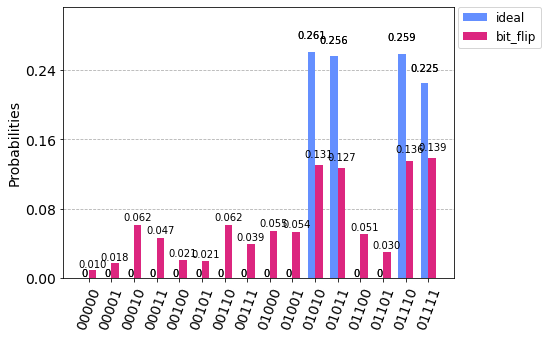

230 142
0.04296875
265 139
0.1044921875
262 130
0.1689453125
267 134
0.23388671875
0 10
0.23876953125
0 18
0.24755859375
0 63
0.2783203125
0 48
0.3017578125
0 22
0.3125
0 21
0.32275390625
0 63
0.353515625
0 40
0.373046875
0 56
0.400390625
0 55
0.42724609375
0 52
0.45263671875
0 31
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375
0 0
0.4677734375


(<Figure size 504x360 with 1 Axes>, 0.4677734375)

In [50]:
bit_error(phase_circ, len(phase_q))

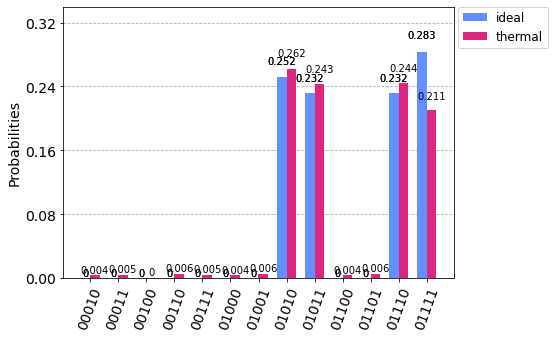

01010
258 136
0.0048828125
01111
290 144
0.041015625
01110
238 143
0.046875
01011
238 123
0.05224609375
00000
0 23
0.05224609375
00001
0 20
0.05224609375
00010
0 55
0.05419921875
00011
0 66
0.056640625
00100
0 21
0.05712890625
00101
0 9
0.05712890625
00110
0 44
0.06005859375
00111
0 49
0.0625
01000
0 49
0.064453125
01001
0 48
0.0673828125
01100
0 43
0.0693359375
01101
0 51
0.072265625
10000


KeyError: '10000'

In [53]:
t1_t2(len(phase_q), phase_circ)

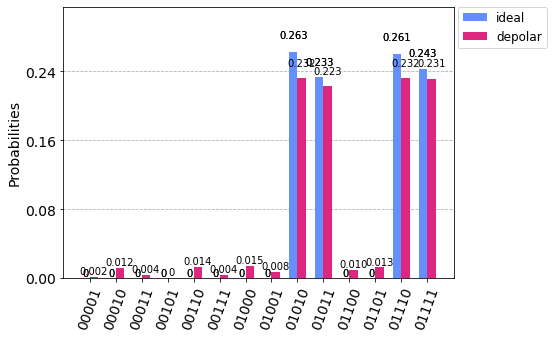

267 139
0.0625
239 161
0.1005859375
249 116
0.16552734375
269 130
0.2333984375
0 17
0.24169921875
0 23
0.2529296875
0 43
0.27392578125
0 50
0.29833984375
0 17
0.306640625
0 23
0.31787109375
0 52
0.34326171875
0 57
0.37109375
0 40
0.390625
0 47
0.41357421875
0 52
0.43896484375
0 57
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875
0 0
0.466796875


(<Figure size 504x360 with 1 Axes>, 0.466796875)

In [28]:
depolar(len(phase_q), phase_circ)

In [29]:
#bit code
bit_q  = QuantumRegister(5)
bit_c = ClassicalRegister(5)
bit_circ = QuantumCircuit(bit_q,bit_c)
bit_circ.barrier()
bit_circ.initialize([1,0], 1)
bit_circ.x(bit_q[2])
bit_circ.initialize([1,0], 3)
bit_circ.barrier()

bit_circ.cx(bit_q[0], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[3])
bit_circ.cx(bit_q[4], bit_q[3])
bit_circ.barrier()
bit_circ.measure(bit_q[0:5],bit_c[0:5])
display(bit_circ.draw())


░                     ░                      ░ ┌─┐            
q410_0: ─░─────────────────────░───■──────────────────░─┤M├────────────
         ░ ┌─────────────────┐ ░ ┌─┴─┐┌───┐           ░ └╥┘┌─┐         
q410_1: ─░─┤ Initialize(1,0) ├─░─┤ X ├┤ X ├───────────░──╫─┤M├─────────
         ░ └──────┬───┬──────┘ ░ └───┘└─┬─┘           ░  ║ └╥┘┌─┐      
q410_2: ─░────────┤ X ├────────░────────■────■────────░──╫──╫─┤M├──────
         ░ ┌──────┴───┴──────┐ ░           ┌─┴─┐┌───┐ ░  ║  ║ └╥┘┌─┐   
q410_3: ─░─┤ Initialize(1,0) ├─░───────────┤ X ├┤ X ├─░──╫──╫──╫─┤M├───
         ░ └─────────────────┘ ░           └───┘└─┬─┘ ░  ║  ║  ║ └╥┘┌─┐
q410_4: ─░─────────────────────░──────────────────■───░──╫──╫──╫──╫─┤M├
         ░                     ░                      ░  ║  ║  ║  ║ └╥┘
  c4: 5/═════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                         0  1  2  3  4

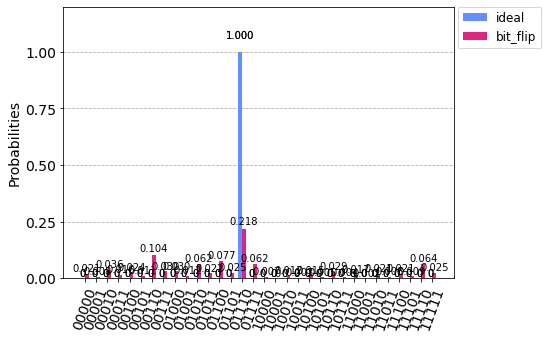

1024 223
0 21
0 8
0 37
0 16
0 25
0 11
0 106
0 31
0 31
0 12
0 64
0 23
0 79
0 26
0 64
0 7
0 1
0 12
0 3
0 15
0 5
0 30
0 4
0 17
0 2
0 21
0 8
0 21
0 9
0 66
0 26


(<Figure size 504x360 with 1 Axes>, 0.7822265625)

In [30]:
bit_error(bit_circ, len(bit_q))

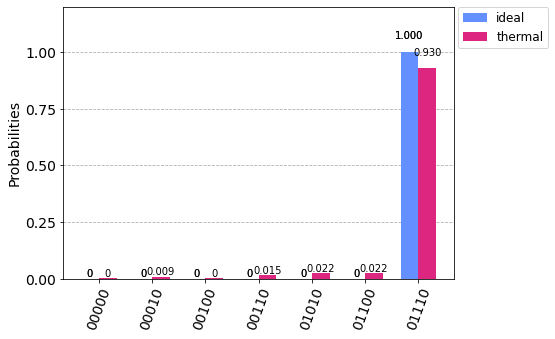

1024 225
0.03515625
0 28
0.03564453125
0 7
0.03564453125
0 38
0.0400390625
0 13
0.0400390625
0 39
0.04052734375
0 10
0.04052734375
0 82
0.0478515625
0 33
0.0478515625
0 29
0.0478515625
0 6
0.0478515625
0 80
0.05908203125
0 18
0.05908203125
0 86
0.0703125
0 31
0.0703125
0 70
0.0703125
0 6
0.0703125
0 3
0.0703125
0 13
0.0703125
0 3
0.0703125
0 9
0.0703125
0 2
0.0703125
0 32
0.0703125
0 8
0.0703125
0 10
0.0703125
0 3
0.0703125
0 21
0.0703125
0 3
0.0703125
0 23
0.0703125
0 5
0.0703125
0 67
0.0703125
0 21
0.0703125


(<Figure size 504x360 with 1 Axes>, 0.0703125)

In [31]:
t1_t2(len(bit_q), bit_circ)

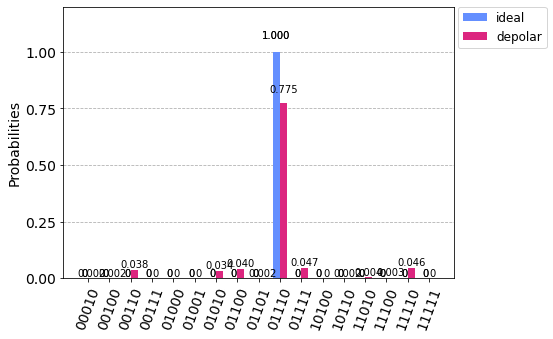

1024 218
0.3935546875
0 28
0.4072265625
0 11
0.41259765625
0 49
0.4365234375
0 9
0.44091796875
0 40
0.46044921875
0 20
0.47021484375
0 102
0.52001953125
0 29
0.5341796875
0 30
0.548828125
0 13
0.55517578125
0 71
0.58984375
0 21
0.60009765625
0 82
0.64013671875
0 29
0.654296875
0 58
0.6826171875
0 7
0.68603515625
0 1
0.6865234375
0 14
0.693359375
0 5
0.69580078125
0 14
0.70263671875
0 4
0.70458984375
0 27
0.7177734375
0 5
0.72021484375
0 7
0.7236328125
0 3
0.72509765625
0 20
0.73486328125
0 5
0.7373046875
0 21
0.74755859375
0 9
0.751953125
0 54
0.7783203125
0 18
0.787109375


(<Figure size 504x360 with 1 Axes>, 0.787109375)

In [32]:
depolar(len(bit_q), bit_circ)

In [33]:
swap_qaoa_q = QuantumRegister(4)
swap_qaoa_c = ClassicalRegister(4)
swap_qaoa_circ = QuantumCircuit(swap_qaoa_q, swap_qaoa_c)
swap_qaoa_circ.h(swap_qaoa_q[0:4])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/3, 0)
swap_qaoa_circ.rz(np.pi/3, 1)
swap_qaoa_circ.rz(np.pi/3, 2)
swap_qaoa_circ.rz(np.pi/3, 3)
swap_qaoa_circ.barrier()
swap_qaoa_circ.measure(swap_qaoa_q[0:4], swap_qaoa_c[0:4])
display(swap_qaoa_circ.draw())


┌───┐                ┌───┐                                          »
q511_0: ┤ H ├──■─────────────┤ X ├──■─────────────────────────■─────────────»
        ├───┤┌─┴─┐┌─────────┐└─┬─┘┌─┴─┐           ┌───┐     ┌─┴─┐┌─────────┐»
q511_1: ┤ H ├┤ X ├┤ Rz(π/2) ├──■──┤ X ├─────■─────┤ X ├──■──┤ X ├┤ Rz(π/2) ├»
        ├───┤└───┘├─────────┤┌───┐└───┘   ┌─┴─┐   └─┬─┘┌─┴─┐└───┘└─────────┘»
q511_2: ┤ H ├──■──┤ Rz(π/2) ├┤ X ├──■─────┤ X ├─────■──┤ X ├──■─────────────»
        ├───┤┌─┴─┐└─────────┘└─┬─┘┌─┴─┐┌──┴───┴──┐     └───┘┌─┴─┐┌─────────┐»
q511_3: ┤ H ├┤ X ├─────────────■──┤ X ├┤ Rz(π/2) ├──────────┤ X ├┤ Rz(π/2) ├»
        └───┘└───┘                └───┘└─────────┘          └───┘└─────────┘»
  c5: 4/════════════════════════════════════════════════════════════════════»
                                                                            »
«        ┌───┐     ┌─────────┐                                 ░ ┌─┐         
«q511_0: ┤ X ├──■──┤ Rz(π/3) ├─────────────────────────────────░─┤M├─────────
«        └─┬─┘┌─┴─┐└─────────┘           ┌───┐     ┌─────────┐ ░ └╥┘┌─┐      
«q511_1: ──■──┤ X ├─────■────────────────┤ X ├──■──┤ Rz(π/3) ├─░──╫─┤M├──────
«        ┌───┐└───┘   ┌─┴─┐   ┌─────────┐└─┬─┘┌─┴─┐├─────────┤ ░  ║ └╥┘┌─┐   
«q511_2: ┤ X ├──■─────┤ X ├───┤ Rz(π/2) ├──■──┤ X ├┤ Rz(π/3) ├─░──╫──╫─┤M├───
«        └─┬─┘┌─┴─┐┌──┴───┴──┐└─────────┘     └───┘└─────────┘ ░  ║  ║ └╥┘┌─┐
«q511_3: ──■──┤ X ├┤ Rz(π/3) ├─────────────────────────────────░──╫──╫──╫─┤M├
«             └───┘└─────────┘                                 ░  ║  ║  ║ └╥┘
«  c5: 4/═════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                 0  1  2  3

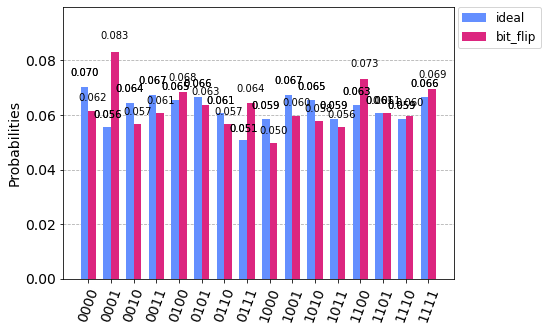

65 75
68 65
66 58
57 85
62 58
67 70
60 57
67 59
68 71
69 61
62 62
69 62
52 66
72 63
60 61
60 51


(<Figure size 504x360 with 1 Axes>, 0.0576171875)

In [35]:
bit_error(swap_qaoa_circ, len(swap_qaoa_q))

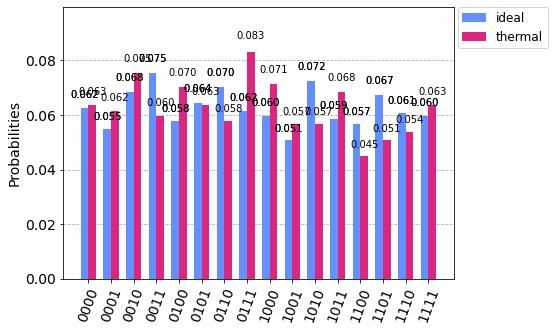

70 55
0.00341796875
62 60
0.0068359375
52 53
0.009765625
56 53
0.01318359375
58 68
0.01904296875
66 69
0.01953125
59 79
0.02587890625
72 58
0.0322265625
61 77
0.0380859375
77 60
0.0458984375
63 72
0.056640625
64 62
0.05712890625
69 71
0.0654296875
60 62
0.0703125
74 66
0.078125
61 59
0.080078125


(<Figure size 504x360 with 1 Axes>, 0.080078125)

In [36]:
t1_t2(len(swap_qaoa_q), swap_qaoa_circ)

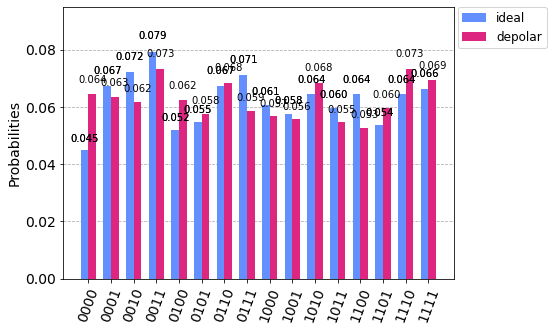

59 49
0.0048828125
55 67
0.0107421875
74 66
0.0146484375
66 62
0.0166015625
56 70
0.0234375
66 49
0.03173828125
62 63
0.0322265625
46 62
0.0400390625
81 67
0.046875
73 71
0.0478515625
61 67
0.05078125
69 79
0.0556640625
53 59
0.05859375
66 62
0.060546875
68 65
0.06201171875
69 66
0.0634765625


(<Figure size 504x360 with 1 Axes>, 0.0634765625)

In [37]:
depolar(len(swap_qaoa_q), swap_qaoa_circ)

In [38]:
vanilla_qaoa_q = QuantumRegister(3)
vanilla_qaoa_c = ClassicalRegister(3)
vanilla_qaoa_circ = QuantumCircuit(vanilla_qaoa_q, vanilla_qaoa_c)
vanilla_qaoa_circ.h(vanilla_qaoa_q[0:3])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.rz(np.pi/2, 1)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/3, 0)
vanilla_qaoa_circ.rz(np.pi/3, 1)
vanilla_qaoa_circ.rz(np.pi/3, 2)
vanilla_qaoa_circ.barrier()
vanilla_qaoa_circ.measure(vanilla_qaoa_q[0:3], vanilla_qaoa_c[0:3])
display(vanilla_qaoa_circ.draw())

┌───┐                                          ┌─────────┐           »
q597_0: ┤ H ├──■───────────────■────■───────────────■──┤ Rz(π/3) ├───────────»
        ├───┤┌─┴─┐┌─────────┐┌─┴─┐  │               │  └─────────┘           »
q597_1: ┤ H ├┤ X ├┤ Rz(π/2) ├┤ X ├──┼───────────────┼───────■────────────────»
        ├───┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐   ┌─┴─┐   ┌─────────┐»
q597_2: ┤ H ├─────────────────────┤ X ├┤ Rz(π/2) ├┤ X ├───┤ X ├───┤ Rz(π/2) ├»
        └───┘                     └───┘└─────────┘└───┘   └───┘   └─────────┘»
  c6: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«                         ░ ┌─┐      
«q597_0: ─────────────────░─┤M├──────
«             ┌─────────┐ ░ └╥┘┌─┐   
«q597_1: ──■──┤ Rz(π/3) ├─░──╫─┤M├───
«        ┌─┴─┐├─────────┤ ░  ║ └╥┘┌─┐
«q597_2: ┤ X ├┤ Rz(π/3) ├─░──╫──╫─┤M├
«        └───┘└─────────┘ ░  ║  ║ └╥┘
«  c6: 3/════════════════════╩══╩══╩═
«                            0  1  2

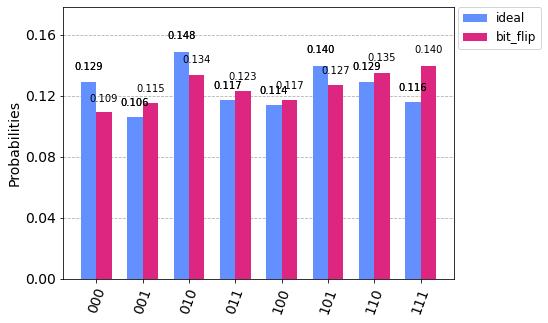

109 118
117 120
132 138
152 137
119 143
132 112
120 126
143 130


(<Figure size 504x360 with 1 Axes>, 0.046875)

In [39]:
bit_error(vanilla_qaoa_circ, len(vanilla_qaoa_q))

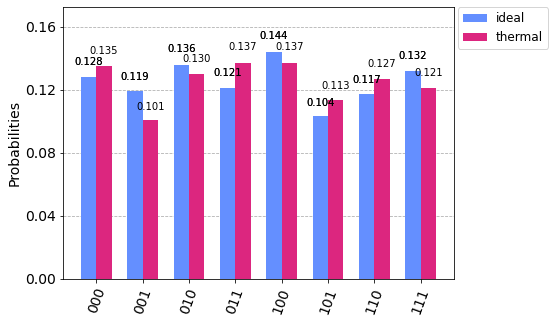

120 137
0.0048828125
147 128
0.00830078125
122 110
0.017578125
106 115
0.0224609375
135 134
0.02783203125
124 127
0.03564453125
131 131
0.0390625
139 142
0.0419921875


(<Figure size 504x360 with 1 Axes>, 0.0419921875)

In [40]:
t1_t2(len(vanilla_qaoa_q), vanilla_qaoa_circ)

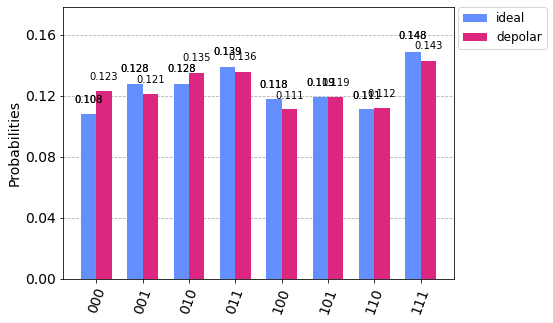

111 114
0.00146484375
152 127
0.013671875
142 120
0.0244140625
131 135
0.0263671875
131 131
0.0263671875
122 120
0.02734375
114 143
0.04150390625
121 134
0.0478515625


(<Figure size 504x360 with 1 Axes>, 0.0478515625)

In [41]:
depolar(len(vanilla_qaoa_q), vanilla_qaoa_circ)

In [42]:
hamilton_q = QuantumRegister(3)
hamilton_c = ClassicalRegister(3)
hamilton_circ = QuantumCircuit(hamilton_q, hamilton_c)
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.rz(np.pi/2, hamilton_q[0:4])
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.rz(np.pi/3, 1)
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.rz(np.pi/3, 2)
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.barrier()
hamilton_circ.measure(hamilton_q[0:3], hamilton_c[0:3])
display(hamilton_circ.draw())

┌───┐┌─────────┐┌───┐                                           ░ ┌─┐»
q683_0: ┤ H ├┤ Rz(π/2) ├┤ H ├──■───────────────■────────────────────────░─┤M├»
        ├───┤├─────────┤├───┤┌─┴─┐┌─────────┐┌─┴─┐                      ░ └╥┘»
q683_1: ┤ H ├┤ Rz(π/2) ├┤ H ├┤ X ├┤ Rz(π/3) ├┤ X ├──■───────────────■───░──╫─»
        ├───┤├─────────┤├───┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐ ░  ║ »
q683_2: ┤ H ├┤ Rz(π/2) ├┤ H ├─────────────────────┤ X ├┤ Rz(π/3) ├┤ X ├─░──╫─»
        └───┘└─────────┘└───┘                     └───┘└─────────┘└───┘ ░  ║ »
  c7: 3/═══════════════════════════════════════════════════════════════════╩═»
                                                                           0 »
«              
«q683_0: ──────
«        ┌─┐   
«q683_1: ┤M├───
«        └╥┘┌─┐
«q683_2: ─╫─┤M├
«         ║ └╥┘
«  c7: 3/═╩══╩═
«         1  2

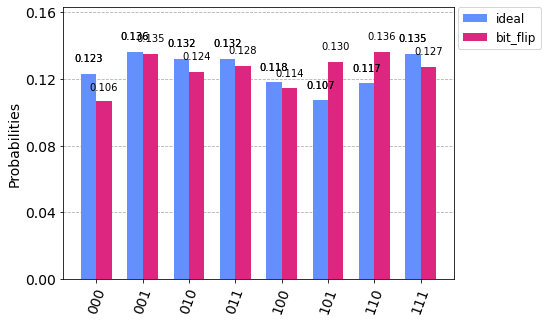

110 133
139 138
120 139
121 117
138 130
135 131
126 109
135 127


(<Figure size 504x360 with 1 Axes>, 0.041015625)

In [43]:
bit_error(hamilton_circ, len(hamilton_q))

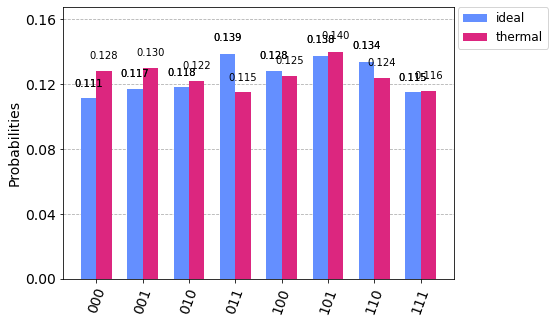

121 140
0.001953125
131 136
0.00341796875
137 128
0.00830078125
114 132
0.0166015625
118 116
0.01708984375
142 121
0.02880859375
141 128
0.02978515625
120 123
0.0361328125


(<Figure size 504x360 with 1 Axes>, 0.0361328125)

In [44]:
t1_t2(len(hamilton_q), hamilton_circ)

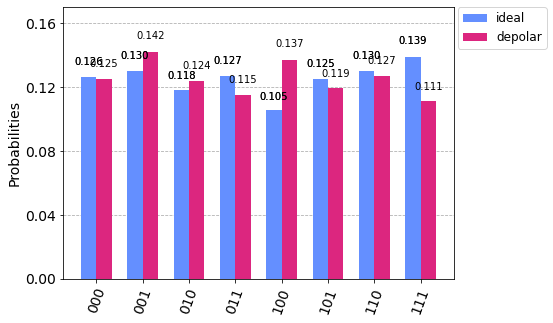

133 128
0.00244140625
128 111
0.0107421875
133 140
0.01416015625
108 125
0.0224609375
121 140
0.03173828125
129 122
0.03515625
142 139
0.03662109375
130 119
0.0419921875


(<Figure size 504x360 with 1 Axes>, 0.0419921875)

In [45]:
depolar(len(hamilton_q), hamilton_circ)